## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
len(df.user_id.unique())

290584

d. The proportion of users converted.

In [6]:
df.query('converted==1').shape[0]/df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
df.query('group=="treatment" & landing_page!="new_page" | group!="treatment" & landing_page=="new_page"').shape[0]

3893

f. Do any of the rows have missing values?

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
#Dropping rows where treatment matches with old_page or control matches with new_page
df.drop(df.query('group=="treatment" & landing_page!="new_page" | group!="treatment" & landing_page=="new_page"').index,inplace=True)

In [10]:
#Dropping rows where control matches with new_page or treatment matches with old_page
df.drop(df.query('group=="control" & landing_page!="old_page" | group!="control" & landing_page=="old_page"').index,inplace=True)

In [11]:
#storing the resulted dataframe in df2
df2=df

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [13]:
len(df2.user_id.unique())

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
df2[df2.user_id.duplicated(keep='first')]['user_id'].to_string(index=False)

'773192'

c. What is the row information for the repeat **user_id**? 

In [15]:
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
df2.drop([2893],inplace=True)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2.query('converted==1').shape[0]/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
df2.query('group=="control" & converted==1').shape[0]/df2.query('group=="control"').shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
df2.query('group=="treatment" & converted==1').shape[0]/df2.query('group=="treatment"').shape[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
(df2['landing_page']=='new_page').mean()

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Answer.** To compare the conversion rate between control group and treatment group, we can see the rate is a bit higher in control group (0.1204) than treatment group (0.1188).This doesn't indicate if the above parameters can be able to soleley detremine the conversion rate is higher in treatment group or not.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer.**
__**$$H_0: p_{new}-p_{old} \leq0$$**__
__**$$H_1: p_{new}-p_{old}>0$$**__

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [21]:
pnew=df2.query('converted==1').shape[0]/df2.shape[0]
pnew

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [22]:
pold=df2.query('converted==1').shape[0]/df2.shape[0]
pold

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [23]:
#nnew stands for the number of individuals in the treatment group
nnew=df2.query('group=="treatment"').shape[0]
nnew

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [24]:
#nold stands for the number of individuals in the control group
nold=df2.query('group=="control"').shape[0]
nold

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [70]:
#simulating values using np.random.choice
new_page_converted = np.random.binomial(1, p=pnew, size=nnew)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [71]:
#simulating values using np.random.choice
old_page_converted = np.random.binomial(1, p=pold, size=nold)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [72]:
#getting difference between sample means
pnew=new_page_converted.mean()
pold=old_page_converted.mean()
pnew-pold

0.00025225851709555214

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [73]:
#bootstrapping 10000 iterations 
new_converted_simulation=np.random.binomial(nnew,pnew, 10000)/nnew
old_converted_simulation=np.random.binomial(nold,pold, 10000)/nold
p_diffs=new_converted_simulation-old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

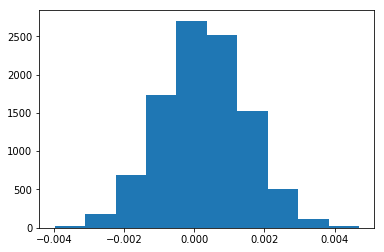

In [74]:
#converting p_diffs into numpy array
p_diffs=np.array(p_diffs)
#plotting histogram
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

**Actual Difference ( Population Mean)**

In [75]:
act_diffs = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()
act_diffs

-0.0015782389853555567

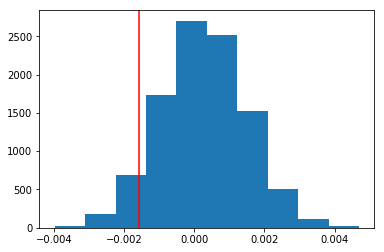

In [76]:
#plotting histogram again
plt.hist(p_diffs)
#Showing actual difference in histogram 
plt.axvline(act_diffs,color='r');

Proportion of **p_diffs** greater than **act_diffs** i.e the **p_value**

In [77]:
#generating p value
(p_diffs>act_diffs).mean()

0.935

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer.** Above parameter represents the p value of the distribution.The large p value (>>0.05 i.e the significane level of committing Type - I error) means there are sufficient circumstances which can prove the null hypothesis is true and thus we failed to reject the null hypothesis.

As a matter, we can conclude that new page conversion doesn't have better effect compare to old page conversion.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [78]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"').converted.sum()
convert_new = df2.query('group=="treatment"').converted.sum()
n_old = nold
n_new = nnew

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [79]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages? Do they agree with the findings in parts **j.** and **k.**?

In [35]:
from scipy.stats import norm

# Determine how significant our z-score is
print(norm.cdf(z_score))

#Determine what our critical value at 95% confidence is for one-sided test
print(norm.ppf(1-(0.05)))


0.9050583127590245
1.6448536269514722


**Answer.**
Since the z-score of 1.31 less than the critical value of 1.64485362695, we fail to reject the null hypothesis which suggest the new page conversion rate is higher than the old rate. 
This z test revelas the autheniticy of the test carried in part j and k and thus it satifies the result obtained those parts.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Ans.**Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
#adding inercept column
df2['intercept']=1
#creating dummy columns
df2[['control', 'ab_page']]=pd.get_dummies(df2['group'])
#dropping control column
df2.drop(labels=['control'], axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [37]:
#importing statsmodel library
import statsmodels.api as sm
#building logistic model
logit = sm.Logit(df2['converted'],df2[['intercept' ,'ab_page']])
results = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
#logistic regression result summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Apr 2019   Pseudo R-squ.:               8.077e-06
Time:                        18:55:10   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Answer:**.The p-value associated with ab_page is **0.19**.We conducted the Hypothesis Test in Part II as a one sided test whereas in Logistic Regression the test result has been derived by two sided test.
Therefore, the null and alternative hypothesis is as follows:
__**$$H_0: p_{new}=p_{old} $$**__
__**$$H_1: p_{new} \neq p_{old}$$**__

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:**.If we consider other things which may lead to a significant result in setting up the trend would be beneficial for the account analysis and may lead to more precise result.However, there could be a possibility to encounter with **Simpson's Paradox** by adding so many features.It is that a trend can appear in several different groups of data but disappears or reverses when these groups are combined.


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

**Merging two dataframes**

In [39]:
#loading countries csv 
countries_df = pd.read_csv('./countries.csv')
#dataframe join
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

**Adding dummy variables**

In [40]:
df_new[['UK', 'US']] = pd.get_dummies(df_new['country'])[['UK','US']]
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


**Setting the Logistic Regression Model**

In [41]:
model = sm.Logit(df_new.converted, df_new[['UK', 'US']])
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.382864
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Apr 2019   Pseudo R-squ.:                -0.04573
Time:                        18:59:28   Log-Likelihood:            -1.1125e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
UK            -1.9868      0.011   -174.174      0.000      -2.009      -1.964
US            -1.9967      0.007   -292.314      0.000      -2.010      -1.983
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

**Determining interaction between page and country**

In [99]:
#creating additional column
df_new['UK_ab_page'] = df_new['UK'] * df_new['ab_page']
df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']
model = sm.Logit(df_new.converted, df_new[['UK', 'US','UK_ab_page','US_ab_page','ab_page']])
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.374250
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Mon, 22 Apr 2019   Pseudo R-squ.:                -0.02220
Time:                        10:39:22   Log-Likelihood:            -1.0875e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
UK            -1.9922      0.016   -123.457      0.000      -2.024      -1.961
US            -1.9865      0.010   -206.344      0.000      -2.005      -1.968
UK_ab_page     2.0823      0.044     47.787      0.000       1.997       2.168
US_ab_page     2.0509      0.040     51.845      0.000       1.973       2.128
ab_page       -2.0715      0.037    -55.798      0.000      -2.144      -1.999
==============================================================================
"""

**Answer:** 
By looking at the logit regression results, we can conclude that there is no significant effect of neither the country or the landing page nor the country and the landing page on the convertion.This can easily be determined as the p values of all those independent variables are set as 0.000 (greater than 0.05 i.e the significance level of commiting type 1 error).
**Hence we failed to reject the null hypothesis**

In conclusion, based on the available data we have neither stastical nor practical reasons to suggest that the new page will result in more conversions than the old page in US or UK.

# Conclusion

After passing through rigorous testing there are no certain evidences which can accumulate the statistical significance of using new pages.All the testing procedure reveals that old page conversion rate is somewhat similar to new page conversion rate and hence we failed to reject the null hypothesis.
While taking this decision we acknowledge the limitations we have, not taking into account some factors such as duration of the tests or else type of users.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!



## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [43]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0